In [1]:
# compare icesat-2 data to ArcticDEM

import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import tarfile
import re
import uuid
import osgeo.gdal 
import zipfile
import io
import shapefile
from shapely.geometry import Polygon, mapping

%matplotlib inline

# load ArcticDEM tiles

# Tyler Sutterley
#-- PURPOSE: read DEM tile file from gzipped tar files
def read_DEM_file(elevation_file):
    #-- open file with tarfile (read)
    tar = tarfile.open(name=elevation_file, mode='r:gz')
    #-- find dem geotiff file within tar file
    member, = [m for m in tar.getmembers() if re.search('dem\.tif',m.name)]
    #-- use GDAL memory-mapped file to read dem
    mmap_name = "/vsimem/{0}".format(uuid.uuid4().hex)
    osgeo.gdal.FileFromMemBuffer(mmap_name, tar.extractfile(member).read())
    ds = osgeo.gdal.Open(mmap_name)
    #-- read data matrix
    im = ds.GetRasterBand(1).ReadAsArray()
    fill_value = ds.GetRasterBand(1).GetNoDataValue()
    #-- get dimensions
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    #-- create mask for finding invalid values
    mask = np.zeros((ysize,xsize),dtype=np.bool)
    indy,indx = np.nonzero(im == fill_value)
    mask[indy,indx] = True
    #-- get geotiff info
    info_geotiff = ds.GetGeoTransform()
    #-- calculate image extents
    xmin = info_geotiff[0]
    ymax = info_geotiff[3]
    xmax = xmin + (xsize-1)*info_geotiff[1]
    ymin = ymax + (ysize-1)*info_geotiff[5]
    #-- close files
    ds = None
    osgeo.gdal.Unlink(mmap_name)
    tar.close()
    #-- create image x and y arrays
    xi = np.arange(xmin,xmax+info_geotiff[1],info_geotiff[1])
    yi = np.arange(ymax,ymin+info_geotiff[5],info_geotiff[5])
    #-- return values (flip y values to be monotonically increasing)
    return (im[::-1,:],mask[::-1,:],fill_value,xi,yi[::-1])


In [6]:
mmap_name = "/vsimem/{0}".format(uuid.uuid4().hex)
mmap_name

'/vsimem/f28a8149050d4f178740d3737783357a'

In [2]:
(im,mask,fill_value, east, north)=read_DEM_file('/home/jovyan/glaciersat2/arcticDEM/40_06_1_1_2m_v3.0.tar.gz')



# load Icesat-2 segments

# calculate and show changes

In [3]:
elevation_file = '/home/jovyan/glaciersat2/arcticDEM/40_06_1_1_2m_v3.0.tar.gz'
tar = tarfile.open(name=elevation_file, mode='r:gz')
#-- find dem geotiff file within tar file
member, = [m for m in tar.getmembers() if re.search('dem\.tif',m.name)]
#-- use GDAL memory-mapped file to read dem
mmap_name = "/vsimem/{0}".format(uuid.uuid4().hex)
    

In [4]:
mmap_name

'/vsimem/be7d0de50a6b4bff9d8a483029655149'

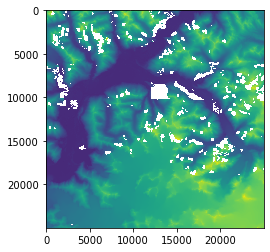

In [5]:
im = np.ma.array(im, mask=mask)
plt.imshow(im)
plt.show()


In [17]:
# load Shape File for Arctic DEM
!wget http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/indexes/ArcticDEM_Tile_Index_Rel7.zip
!mv ArcticDEM_Tile_Index_Rel7.zip /home/jovyan/glaciersat2/arcticDEM/


--2019-06-19 00:45:28--  http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/indexes/ArcticDEM_Tile_Index_Rel7.zip
Resolving data.pgc.umn.edu (data.pgc.umn.edu)... 134.84.212.106
Connecting to data.pgc.umn.edu (data.pgc.umn.edu)|134.84.212.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538740 (526K) [application/zip]
Saving to: ‘ArcticDEM_Tile_Index_Rel7.zip’

ArcticDEM_Tile_Inde 100%[===================>] 526.11K  2.64MB/s    in 0.2s    

2019-06-19 00:45:28 (2.64 MB/s) - ‘ArcticDEM_Tile_Index_Rel7.zip’ saved [538740/538740]



In [6]:
#-- PURPOSE: read zip file containing index shapefiles for finding DEM tiles
# function from T. Sutterley


def read_DEM_index(elevation_index_file, HEM):
    
    import zipfile
    import io
    
    #-- extract zip file with shapefile index
    zs = zipfile.ZipFile(elevation_index_file)
    dbf,prj,shp,shx = [io.BytesIO(zs.read(s)) for s in sorted(zs.namelist())]
    #-- read the shapefile and extract entities
    shape_input = shapefile.Reader(dbf=dbf,prj=prj,shp=shp,shx=shx)
    shape_entities = shape_input.shapes()
    shape_attributes = shape_input.records()
    shape_field_names = [f[0] for f in shape_input.fields[1:]]
    #-- extract attribute indice for DEM tile (REMA) or objectid (ArcticDEM)
    if (HEM == 'S'):
        #-- REMA index file attributes:
        #-- name: DEM mosaic name for tile (file name without suffix)
        #-- tile: DEM tile identifier (IMy_IMx)
        #-- nd_value: fill value for elements with no data
        #-- resolution: DEM horizontal spatial resolution (meters)
        #-- creationda: creation date
        #-- raster: (empty)
        #-- fileurl: link to file on PGC server
        #-- spec_type: specific type (DEM)
        #-- qual: density of scenes within tile (0 to 1)
        #-- reg_src: DEM registration source (ICESat or neighbor align)
        #-- num_gcps: number of ground control points
        #-- meanresz: mean vertical residual (meters)
        #-- active: (1)
        #-- qc: (2)
        #-- rel_ver: release version
        #-- num_comp: number of components
        #-- st_area_sh: tile area (meters^2)
        #-- st_length_: perimeter length of tile (meters)
        ind, = [i for i,f in enumerate(shape_field_names) if (f == 'tile')]
    elif (HEM == 'N'):
        #-- ArcticDEM index file attributes:
        #-- objectid: DEM tile object identifier for sub-tile
        #-- name: DEM mosaic name for sub-tile (file name without suffix)
        #-- tile: DEM tile identifier (IMy_IMx) (non-unique for sub-tiles)
        #-- nd_value: fill value for elements with no data
        #-- resolution: DEM horizontal spatial resolution (meters)
        #-- creationda: creation date
        #-- raster: (empty)
        #-- fileurl: link to file on PGC server
        #-- spec_type: specific type (DEM)
        #-- qual: density of scenes within tile (0 to 1)
        #-- reg_src: DEM registration source (ICESat or neighbor align)
        #-- num_gcps: number of ground control points
        #-- meanresz: mean vertical residual (meters)
        #-- active: (1)
        #-- qc: (2)
        #-- rel_ver: release version
        #-- num_comp: number of components
        #-- st_area_sh: tile area (meters^2)
        #-- st_length_: perimeter length of tile (meters)
        ind, = [i for i,f in enumerate(shape_field_names) if (f == 'objectid')]
    #-- create python dictionary for each polygon object
    poly_dict = {}
    attrs_dict = {}
    #-- extract the entities and assign by tile name
    for i,ent in enumerate(shape_entities):
        #-- name or objectid of tile
        tile = str(shape_attributes[i][ind])
        #-- extract attributes and assign by tile
        attrs_dict[tile] = {}
        for j,field in enumerate(shape_field_names):
            attrs_dict[tile][field] = shape_attributes[i][j]
        #-- extract Polar Stereographic coordinates for entity
        points = np.array(ent.points)
        poly_obj = Polygon(list(zip(points[:,0], points[:,1])))
        #-- Valid Polygon may not possess overlapping exterior or interior rings
        if (not poly_obj.is_valid):
            poly_obj = poly_obj.buffer(0)
        poly_dict[tile] = poly_obj
    #-- close the zipfile
    zs.close()
    #-- return the dictionaries of polygon objects and attributes
    return poly_dict,attrs_dict


In [7]:
# this finds the correct tile index in the Arctic DEM shapefile

import shapefile
from shapely.geometry import Polygon, MultiPoint

poly_dict, attrs_dict = read_DEM_index('/home/jovyan/glaciersat2/arcticDEM/ArcticDEM_Tile_Index_Rel7.zip', HEM='N')

for key in attrs_dict.keys():
    if attrs_dict[key]['name']=='40_06_1_2_2m_v3.0':
        tile_key = key
        dem_bbox = poly_dict[tile_key]
        break
        

In [49]:
# extract the DEM bounding box

#zs = zipfile.ZipFile('/home/jovyan/glaciersat2/arcticDEM/ArcticDEM_Tile_Index_Rel7.zip')
#dbf,prj,shp,shx = [io.BytesIO(zs.read(s)) for s in sorted(zs.namelist())]
#-- read the shapefile and extract entities
#shape_input = shapefile.Reader(dbf=dbf,prj=prj,shp=shp,shx=shx)
#dem_bbox = shape_input.shapeRecords()[index].shape.__geo_interface__  

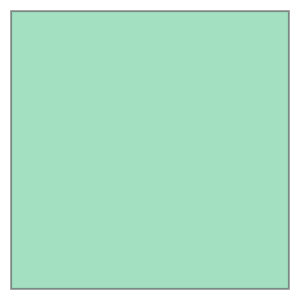

In [63]:
dem_bbox
#shape_input.shapeRecords()[index].shape.bbox

In [18]:
# ok, we'll look at icesat tracks now
# copied from redu-is2-files notebook

def list_files_local(path):
    """ Get file list form local folder. """
    from glob import glob
    return glob(path)

files = list_files_local('/home/jovyan/glaciersat2/juneauicefield/*.h5')



In [2]:
# copied from Clouds and data quality notebook

import numpy as np
import h5py


def ATL06_to_dict(filename, dataset_dict):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            dataset_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a list of numpy arrays containing the 
                data
    """
    
    D6=[]
    pairs=[1, 2, 3]
    beams=['l','r']
    # open the HDF5 file
    with h5py.File(filename) as h5f:
        # loop over beam pairs
        for pair in pairs:
            # loop over beams
            for beam_ind, beam in enumerate(beams):
                # check if a beam exists, if not, skip it
                if '/gt%d%s/land_ice_segments' % (pair, beam) not in h5f:
                    continue
                # loop over the groups in the dataset dictionary
                temp={}
                for group in dataset_dict.keys():
                    for dataset in dataset_dict[group]:
                        DS='/gt%d%s/%s/%s' % (pair, beam, group, dataset)
                        # since a dataset may not exist in a file, we're going to try to read it, and if it doesn't work, we'll move on to the next:
                        try:
                            temp[dataset]=np.array(h5f[DS])
                            # some parameters have a _FillValue attribute.  If it exists, use it to identify bad values, and set them to np.NaN
                            if '_FillValue' in h5f[DS].attrs:
                                fill_value=h5f[DS].attrs['_FillValue']
                                bad=temp[dataset]==fill_value
                                temp[dataset]=np.float64(temp[dataset])
                                temp[dataset][bad]=np.NaN
                        except KeyError as e:
                            pass
                if len(temp) > 0:
                    # it's sometimes convenient to have the beam and the pair as part of the output data structure: This is how we put them there.
                    temp['pair']=np.zeros_like(temp['h_li'])+pair
                    temp['beam']=np.zeros_like(temp['h_li'])+beam_ind
                    temp['filename']=filename
                    D6.append(temp)
    return D6

In [122]:
# loop through all icesat tracks and check if they fall within the DEM bounding box

import glob
import pyproj
from shapely.geometry import MultiPoint

# transform function
def transform_coord(proj1, proj2, x, y):
    """
    Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projs:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert

files = glob.glob('/home/jovyan/glaciersat2/juneauicefield/*.h5')

all_data = []
new_data = []
dataset_dict={'land_ice_segments':['h_li','longitude','latitude']}

for file in files[0:10]:
    new_data = ATL06_to_dict(file, dataset_dict)
    
    # look at all beams
    
    for beam in range(len(new_data)):
        # convert to epsg 3413
        x,y = transform_coord('4326','3413', new_data[beam]['longitude'], new_data[beam]['latitude'])
    
        # convert to MultiPoint and test whether the track is in the DEM polygon
        #x = [-4000000, -3470000, -3300000]
        #y = [-10000,-3000,1000]
        points = MultiPoint(list(zip(x,y)))
        
        quit = False
    
        int_test = dem_bbox.intersects(points) # True if there are common points
        if int_test:
            
            int_map = list(map(dem_bbox.intersects,points)) # which points are inside?
            new_data[beam]['mask'] = int_map
            quit = True
            all_data.append(new_data[beam])
            print(len(all_data))
            
    if quit:
        break

1
2
3
4
5
6


In [1]:
# Start over here

# ok on to comparison with the Arctic DEM

import os
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
import glob
import pyproj
from shapely.geometry import MultiPoint

# transform function
def transform_coord(proj1, proj2, x, y):
    """
    Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projs:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert

# load and Arctic DEM tile

adem = '/home/jovyan/glaciersat2/arcticDEM/40_06_1_2_2m_v3.0_reg_dem.tif'

#This is rasterio Dataset object
src_proj = rio.open(adem)

# read the DEM file
adem_proj = src_proj.read(1).astype(float)
adem_proj[adem_proj==src_proj.nodata] = np.nan

In [78]:
# load icesat-2 tracks

files = glob.glob('/home/jovyan/glaciersat2/juneauicefield/*.h5')

dataset_dict={'land_ice_segments':['h_li','longitude','latitude','atl06_quality_summary','delta_time']}
# atl06_quality_summary is binary, 1 for good

x_ps = np.array([])
y_ps = np.array([])
dz = np.array([])
good = np.array([])
is_time = np.array([])

for file in files:
    new_data = ATL06_to_dict(file, dataset_dict)
    
    # look at all beams
    
    for beam in range(len(new_data)):
        # convert to epsg 3413
        x,y = transform_coord('4326','3413', new_data[beam]['longitude'], new_data[beam]['latitude'])
    
        # convert to MultiPoint and test whether the track is in the DEM polygon
       
        points = MultiPoint(list(zip(x,y)))
        
        quit = False
    
        int_test = dem_bbox.intersects(points) # True if there are common points
        if int_test:
            
            int_map = list(map(dem_bbox.intersects,points)) # which points are inside?
            
            x_inside = x[int_map]
            y_inside = y[int_map]
            qual = new_data[beam]['atl06_quality_summary'][int_map]
            
            atl_coord = list(zip(x_inside,y_inside))
            
            adem_sample = list((src_proj.sample(atl_coord, 1)))
            adem_sample_elev = np.squeeze(adem_sample).astype(float)
            
            dh = new_data[beam]['h_li'][int_map]-adem_sample_elev
            
            # crude filter
            dh[np.abs(dh)>10] = np.nan
            
            x_ps = np.hstack((x_ps, x_inside))
            y_ps = np.hstack((y_ps, y_inside))
            dz = np.hstack((dz, dh))
            good = np.hstack((good,qual))
            

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


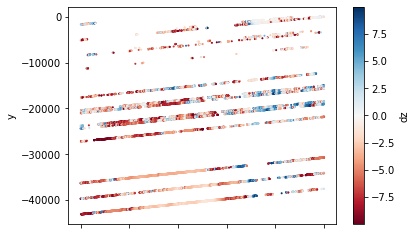

In [86]:
import pandas as pd
import geopandas as gpd

dz_df = pd.DataFrame()
dz_df['x'] = x_ps
dz_df['y'] = y_ps
dz_df['dz'] = dz
dz_df['good'] = good

dz_df.plot(x='x', y='y', kind='scatter', c='dz', s=1, cmap='RdBu')
good_bool = (good>0.5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe3daa6ed30>]],
      dtype=object)

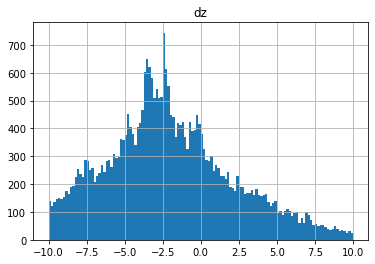

In [80]:
dz_df.hist('dz',bins=128)

In [88]:
!gdaldem hillshade ./arcticDEM/40_06_1_2_2m_v3.0_reg_dem.tif hs.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
hs_proj = rio.open('hs.tif')
hs = hs_proj.read(1).astype(float)

In [ ]:
f, ax = plt.subplots()
ax.imshow(hs, cmap='gray', extent=rio.plot.plotting_extent(hs_proj))
glas_gdf_utm_wa.plot('srtm_90m_z_rio', ax=ax, edgecolor='w', cmap='inferno')